# Домашнее задание

1. Генерим 21 сигналов (временных рядов), 3 класса по 7 образцов в каждом. 
Постарайтесь сделать их как можно более похожими, и в тоже время различными. 

1. Рассчитываем расстояние между ними по формуле Евклида и с помощью DTW

1. Описываем кратко полученные значения

1. Формируем из нагенеренных временных рядов набор данных для обучения

1. Разбиваем набор на train и test

1. Обучаем  классификаторы KNN с DTW, KNN со стандартной метрикой расстояния, TimeSeriesForest

1. Описываем кратко полученные результаты

### Генерация рядов

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [230]:
SIZE_TS = 100
NUMB_TS = 7
STEP = 1

In [231]:
def pulse(t):
    if 0.15 < t < 0.15 + STEP:
        return 2
    elif 0.65 < t < 0.65 + 1.5*STEP:
        return -1
    elif 1.15 < t < 1.15 + 1.5*STEP:
        return 2
    else:
        return 0
    
pulse = np.vectorize(pulse,otypes=[np.float64])

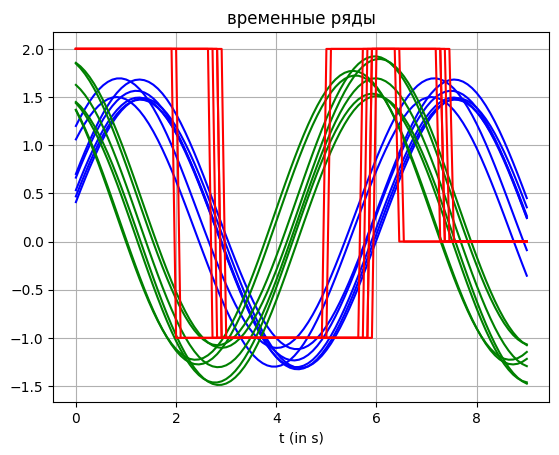

In [255]:
#  индекс и отсчет времени в секундах
time = np.linspace(0, 9, SIZE_TS)

tseries_list = {'Time': time}
rand = np.random.random(size=10)

for i in range(NUMB_TS):
    tseries_list["Tsin" + str(i)] = 1.4 * np.sin(time +  rand[i]) + random.uniform(0, 0.3)
    tseries_list["Tcos" + str(i)] = 1.5 * np.cos(time +  rand[i]) + random.uniform(0, 0.5)
    mean = random.uniform(0.3, 1)
    std = random.uniform(0.5, 1.5)
    tseries_list["Tpls" + str(i)] = pulse((time + 2*rand[i])/3)

# отрисовка всех сигналов
for i in range(NUMB_TS):
    plt.plot(time, tseries_list["Tsin"+str(i)], '-b')
for i in range(NUMB_TS):
    plt.plot(time, tseries_list["Tcos"+str(i)], '-g')
for i in range(NUMB_TS):
    plt.plot(time, tseries_list["Tpls"+str(i)], '-r')
            
plt.title(r'временные ряды')
plt.xlabel(r't (in s)')
plt.grid()

### Подсчет расстояний

In [256]:
def distance_matrix(x, y, q) -> np.array:
    """
    Функция  рассчета  матрицы  расстояний между точками двух рядов 
    """
    mdist = np.zeros((len(y), len(x)))
    for i in range(len(y)):
        for j in range(len(x)):
            mdist[i,j] = np.abs((x[j]-y[i]))**q
    return mdist

In [257]:
def DTW(x, x_s, q=1, isDTW=True):
    '''
        x: первый ряд
        x_s : второй ряд
        q : степень для вычисления базового расстояния
    '''
    N = len(x) # Считаем, что ряды равной длины. Но это не всегда так, перепишите функцию для 
               # вычисления расстояния между рядами, длины которых не равны
    
    # Строим матрицу согласно реккурентной формуле, полученной выше. Матрица в нашем случае будет размерности 
    dist = distance_matrix(x,x_s,q=2)
    
    R = [[0] * (N+1) for i in range(N+1)]
   
    for i in range(1,N): 
        R[i][0] = dist[i,0] + R[i-1][0] 
        R[0][i] = dist[0,i] + R[0][i-1]

    k = 0
    if isDTW:
        k = 1
  
    for i in range(1,N+1): 
        for j in range(1,N+1):
            R[i][j] = dist[i-1,j-1] + k*np.min([R[i-1][j-1], R[i][j-1], R[i-1][j]])

    # ищем минимальный путь. Начинаем от нижнего правого угла.
    pth = []   # лист с кортежами индексов пути
    i = N
    j = N
    while i >= 0 and j >= 0:
        pth.append((i,j))
        if R[i][j-1] <= R[i-1][j-1] and R[i][j-1] <= R[i-1][j]:
            I = i
            J = j-1                
        
        if R[i-1][j] <= R[i-1][j-1] and R[i-1][j] <= R[i][j-1]:
            I = i - 1
            J = j 

        if R[i-1][j-1] <= R[i][j-1] and R[i-1][j-1] <= R[i-1][j]:
            I = i - 1
            J = j - 1
        
        i = I
        j = J

    #Считаем расстояние между двумя рядами
    s = 0
    for l in pth:
        s += R[l[0]][l[1]]
    s = s/len(pth) 

    return s, pth, R

In [258]:
# Посчитаем DTW для двух временных рядов

#для простоты выделяем ряды, которые будем сравнивать
x = np.abs(tseries_list["Tsin1"])
x_s = np.abs(tseries_list["Tsin5"])
x_p = np.abs(tseries_list["Tpls1"])
s1 = DTW(x,x_s,q=2)
s2 = DTW(x,x_p,q=2)

print (f"DTW\nTsin1 и Tsin5 = {s1[0]}     Tsin1 и Tpls1 = {s2[0]}")

s11 = DTW(x,x_s,q=2, isDTW=False)
s21 = DTW(x,x_p,q=2, isDTW=False)

print (f"Dec\nTsin1 и Tsin5 = {s11[0]}     Tsin1 и Tpls1 = {s21[0]}")

DTW
Tsin1 и Tsin5 = 0.15060034591224655     Tsin1 и Tpls1 = 16.834626802251943
Dec
Tsin1 и Tsin5 = 0.006816565341774999     Tsin1 и Tpls1 = 0.20070274011795272


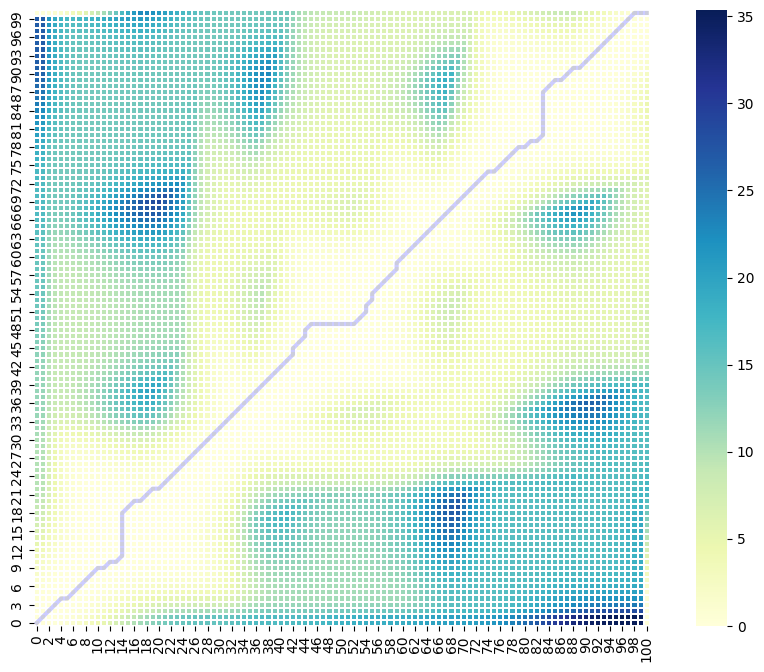

In [259]:
import seaborn as sbn
# Отрисуем матрицы весов расстояний Ts1 и Ts3 

cost_matrix = s1[2]
warp_path = s1[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

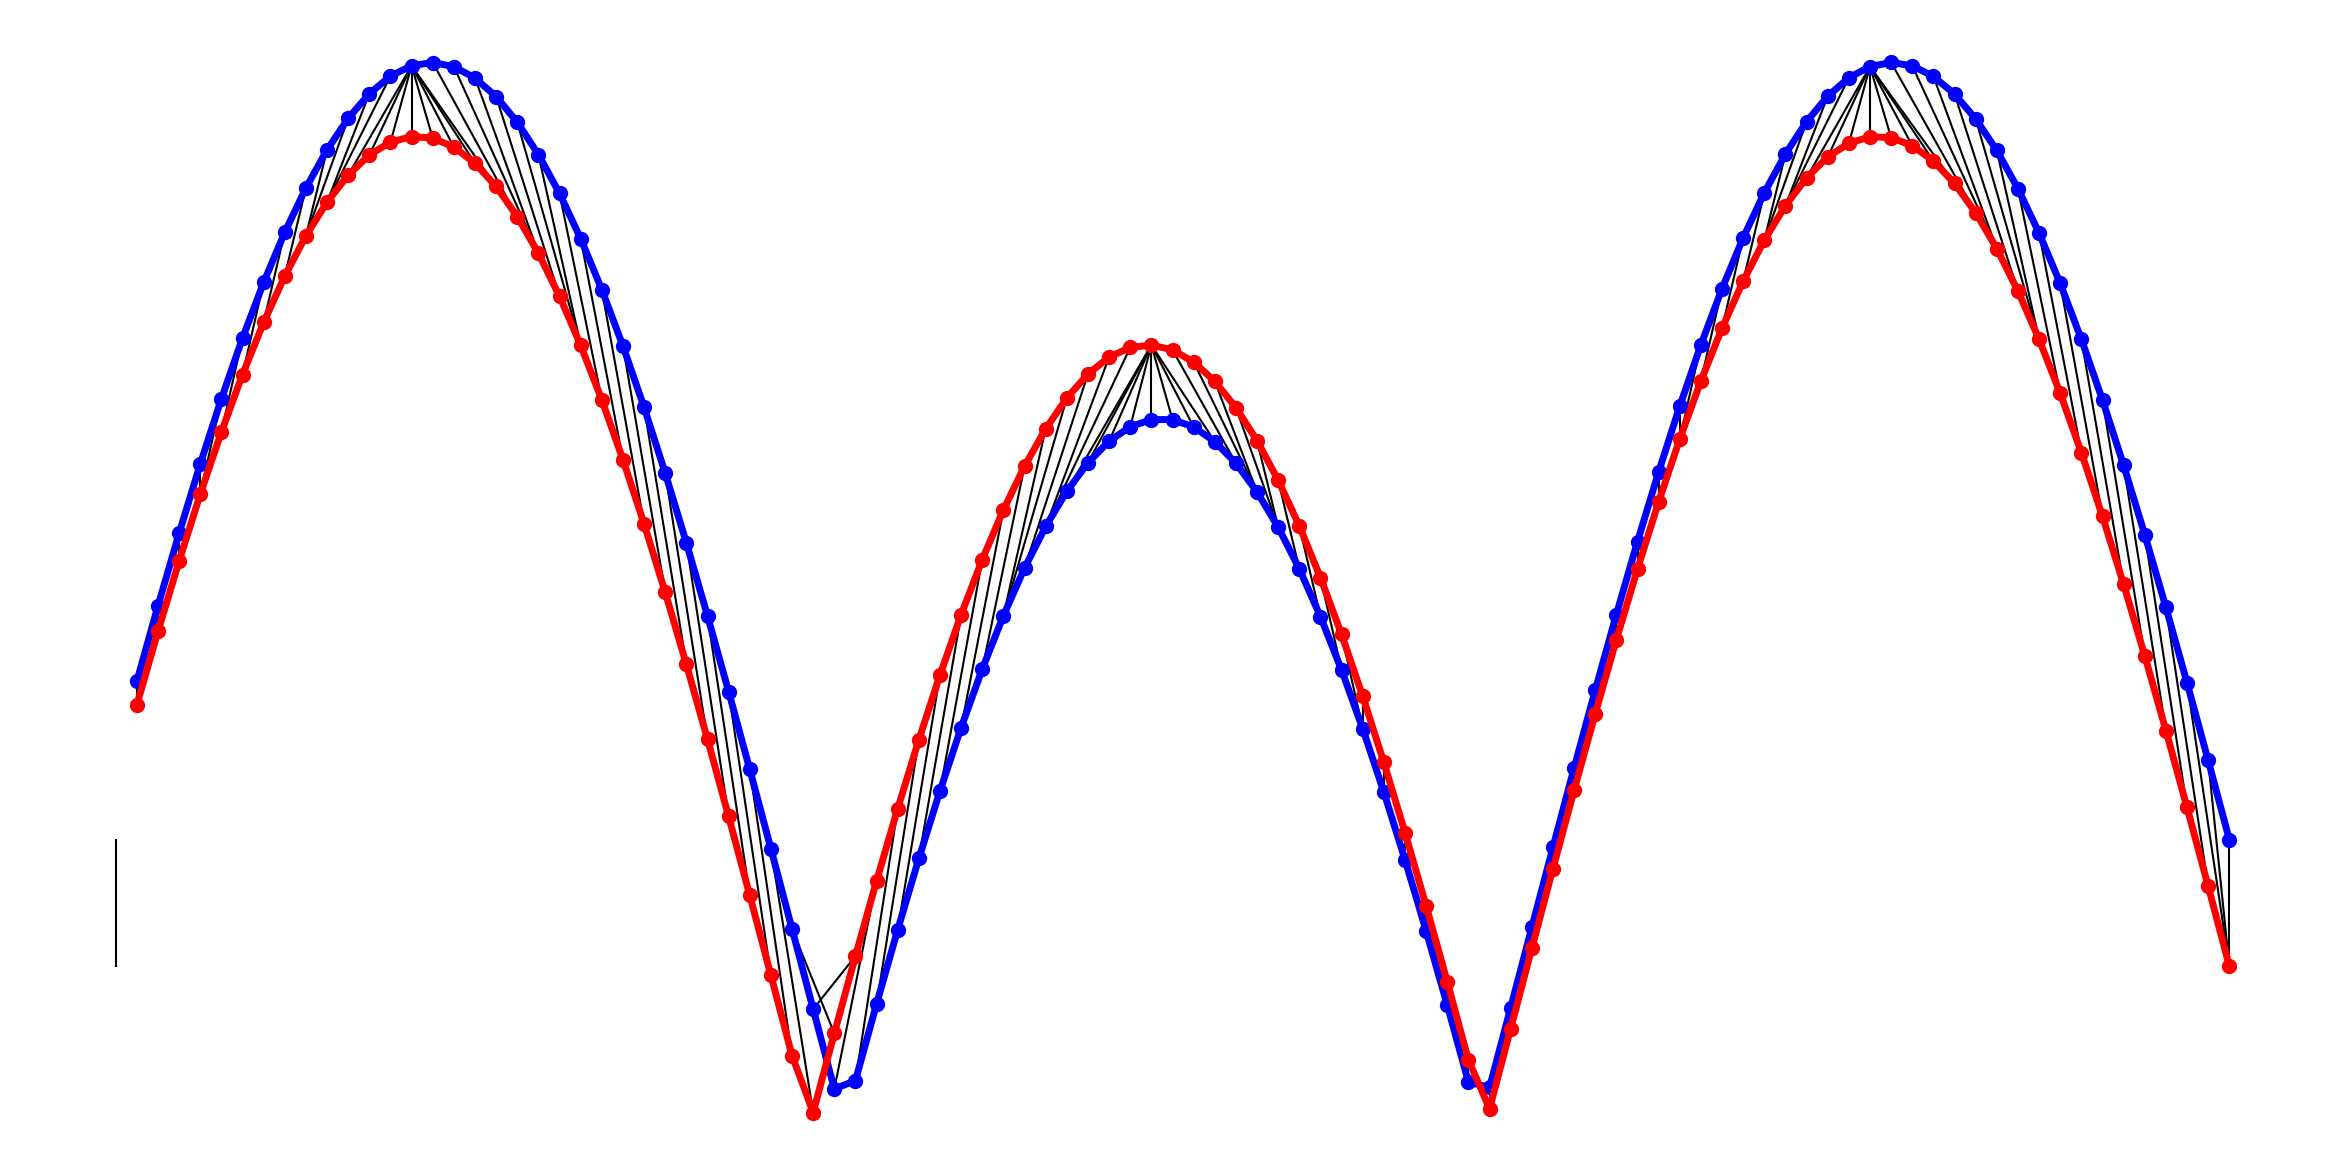

In [260]:
fig, ax = plt.subplots(figsize=(30, 15))

warp_path = s1[1]
x1 = x
x2 = x_s

fig.patch.set_visible(True)
ax.axis('off')

for [map_x, map_y] in warp_path:   
    ax.set_facecolor('white')
    ax.plot([map_x-1, map_y-1], [x1[map_x-1], x2[map_y-1]], '-k')

ax.plot(x1, color='blue', marker='o', markersize=10, linewidth=5)
ax.plot(x2, color='red', marker='o', markersize=10, linewidth=5)
ax.tick_params(axis="both", which="major", labelsize=18)

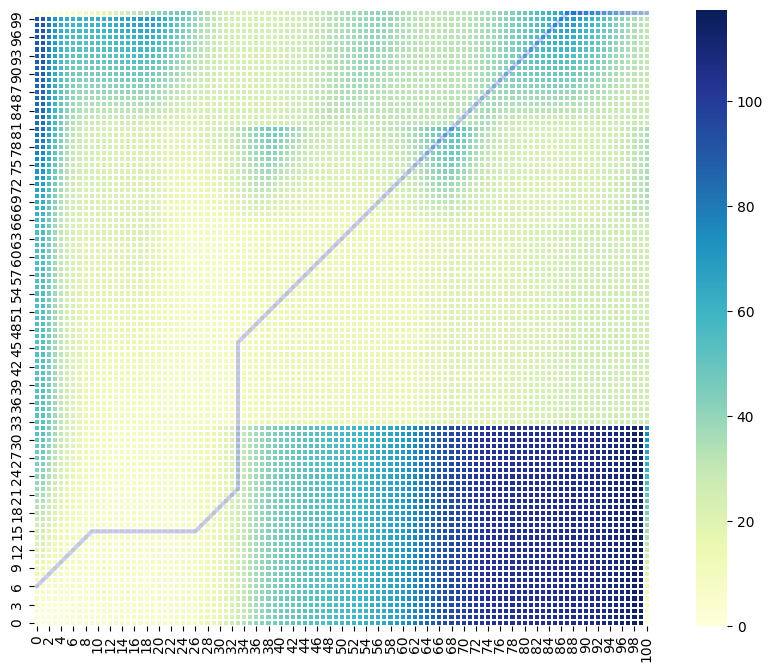

In [261]:
# Отрисуем матрицы весов расстояний Ts1 и Tp1

cost_matrix = s2[2]
warp_path = s2[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

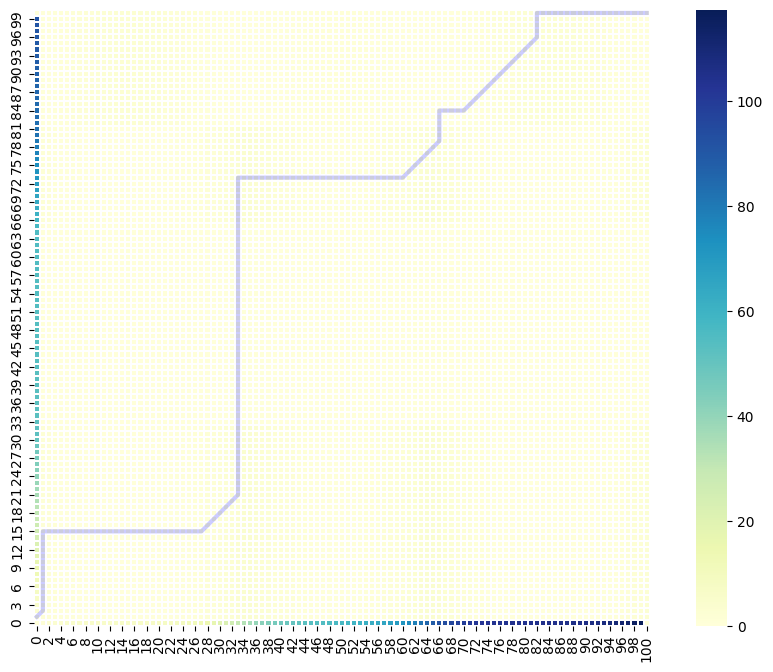

In [262]:
# Отрисуем матрицы весов расстояний Ts1 и Tp1 без DTW

cost_matrix = s21[2]
warp_path = s21[1]

fig, ax = plt.subplots(figsize=(12, 8))
ax = sbn.heatmap(cost_matrix, square=True, linewidths=0.1, cmap="YlGnBu", ax=ax)
ax.invert_yaxis()


path_x = [p[0] for p in warp_path]
path_y = [p[1] for p in warp_path]

path_xx = [x+0.5 for x in path_x]
path_yy = [y+0.5 for y in path_y]

ax.plot(path_xx, path_yy, color='blue', linewidth=3, alpha=0.2)

In [263]:
from dtaidistance import dtw

x = np.abs(tseries_list["Tsin1"])
x_s = np.abs(tseries_list["Tsin5"])


distance, paths = dtw.warping_paths(x, x_s)
print(distance)
print(paths)

0.5809467889227155
[[0.                inf        inf ...        inf        inf        inf]
 [       inf 0.03759336 0.08759379 ... 5.16015584 5.17035391 5.18999446]
 [       inf 0.16156267 0.05519872 ... 4.62156603 4.64285572 4.67779037]
 ...
 [       inf 5.94264456 5.31949419 ... 0.57605397 0.66015202 0.79834314]
 [       inf 5.94329021 5.32341636 ... 0.54300157 0.57844996 0.66393688]
 [       inf 5.94710865 5.3336219  ... 0.5402496  0.54528132 0.58094679]]


(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

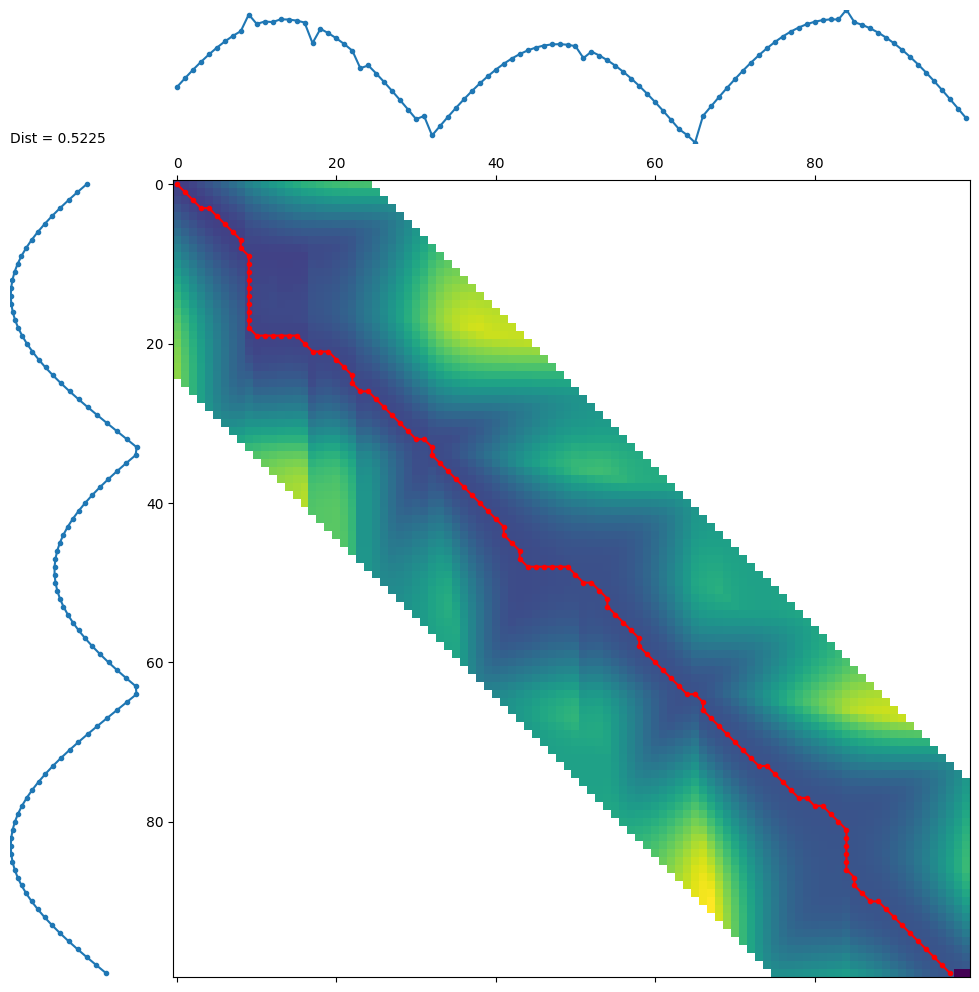

In [264]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
xw = np.arange(0, 20, .5)
s1 = x
s2 = x_s
random.seed(1)
for idx in range(len(s2)):
    if random.random() < 0.05:
        s2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

In [265]:
x = np.abs(tseries_list["Tsin1"])
x_p = np.abs(tseries_list["Tpls2"])


distance, paths = dtw.warping_paths(x, x_p)
print(distance)
print(paths)

5.710249149858796
[[ 0.                 inf         inf ...         inf         inf
          inf]
 [        inf  1.29856946  1.83645454 ...  9.60455056  9.6301296
   9.65564089]
 [        inf  1.75396851  1.75396851 ...  8.9183827   8.95608921
   8.99363764]
 ...
 [        inf 10.71000599 10.71000599 ...  5.98396617  6.02468667
   6.06513378]
 [        inf 10.80422763 10.80422763 ...  5.81097955  5.8394803
   5.86784263]
 [        inf 10.91473709 10.91473709 ...  5.67455549  5.6924303
   5.71024915]]


(<Figure size 1000x1000 with 4 Axes>, [<Axes: >, <Axes: >, <Axes: >, <Axes: >])

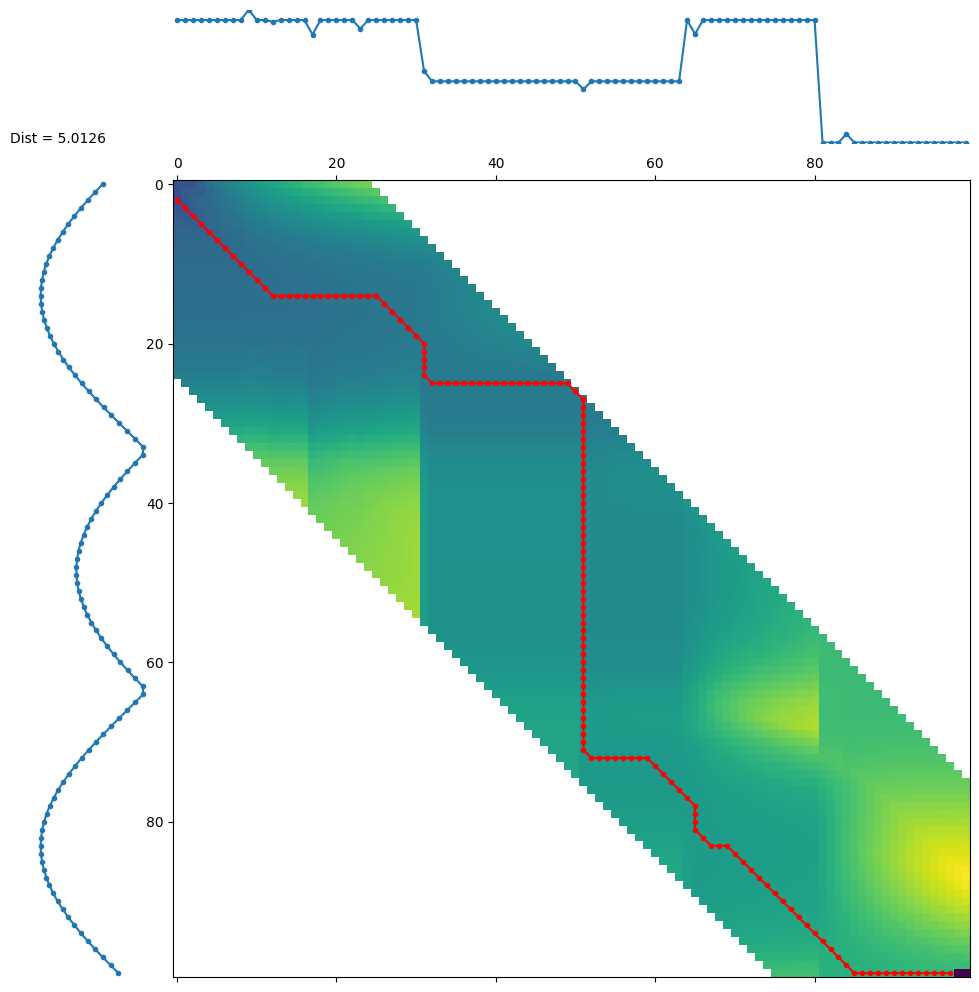

In [266]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import random
import numpy as np
xw = np.arange(0, 20, .5)
s1 = x
s2 = x_p
random.seed(1)
for idx in range(len(s2)):
    if random.random() < 0.05:
        s2[idx] += (random.random() - 0.5) / 2
d, paths = dtw.warping_paths(s1, s2, window=25, psi=2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

### Обучение

In [267]:
x = []  #значения
Y = []  # целевая переменная

for v in tseries_list:
    if v!= 'Time':
        x.append(tseries_list[v])
        c = v[:-1]
        if c == "Tsin":
            Y.append(0)
        elif c == "Tcos":
            Y.append(1)
        else: Y.append(2)


arr = np.arange(len(Y))
np.random.shuffle(arr)
print(Y)

X_train = []
X_test = []
y_train = []
y_test = []

for i in arr[:-5]:
    X_train.append(x[i])
    y_train.append(Y[i])

for i in arr[len(X_train):]:
    X_test.append(x[i])
    y_test.append(Y[i])

[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]


In [268]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='minkowski')
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[2].reshape(1, -1))}")
print(f"Истинный класс для предсказаний {y_test[2]}")

Accuracy 1.0
Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0


In [269]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='dtw')
clf.fit(X_train, y_train)

print(f"Accuracy {clf.score(X_test, y_test)}")
print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[2].reshape(1, -1))}")
print(f"Истинный класс для предсказаний {y_test[2]}")

Accuracy 1.0
Вектор вероятности принадлежности к классам [[1. 0. 0.]]
Истинный класс для предсказаний 0


In [270]:
import numpy as np 
from pyts.classification import TimeSeriesForest
import matplotlib.pyplot as plt

 
clf = TimeSeriesForest(random_state=43)
clf.fit(X_train, y_train)


print(f"Accuracy {clf.score(X_test, y_test)}")
print(f"Вектор вероятности принадлежности к классам {clf.predict_proba(X_test[2].reshape(1, -1))}")
print(f"Истинный класс для предсказаний {y_test[2]}")

Accuracy 1.0
Вектор вероятности принадлежности к классам [[0.828 0.114 0.058]]
Истинный класс для предсказаний 0
